# NMME Niño 3.4

In [50]:
import numpy as np
import xarray as xr

import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [51]:
nmme_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/'
n34_url = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'

In [52]:
model_list = ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2']

## Functions

In [53]:
# For the IRI DL 'months since' unit
def decode_cf(ds, time_var):
    if ds[time_var].attrs['calendar'] == '360':
        ds[time_var].attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds, decode_times=True)
    return ds

In [54]:
# correlation as function of start month
def ac_by_start(x, y):
    xa = x.groupby('S.month') - x.groupby('S.month').mean('S') 
    ya = y.groupby('S.month') - y.groupby('S.month').mean('S') 
    c = (xa*ya).groupby('S.month').mean('S')/xa.groupby('S.month').std('S')/ya.groupby('S.month').std('S')
    c.attrs['long_name'] = 'correlation'
    c.month.attrs['long_name'] = 'start month'
    return c

In [55]:
# MSE skill score as a function of start month
def msess_by_start(f, o):
    # assumes:
    # 1. f and o are anomalies (the mean is not removed here)
    # 2. the reference forecast is zero anomaly
    # Note: use mean instead of sum to get the desired nan behavior (nan if all values missing. e.g., models with shorter forecasts)
    msess = 1.0 - ((f - o)**2).groupby('S.month').mean('S')/(o**2).groupby('S.month').mean('S')
    msess.attrs['long_name'] = 'MSESS'
    msess.month.attrs['long_name'] = 'start month'
    return msess

# Read data

## Obserations (ERSSTv5)

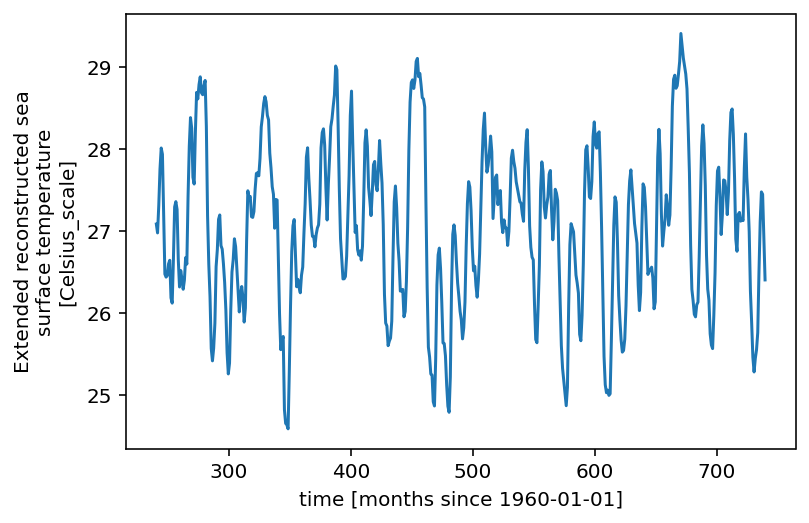

In [56]:
#Observations do not have to match the forecasts

# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
time_str = 'T/(Jan%201980)/last/RANGE/'
obs_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + n34_url + 'zlev/removeGRID/' + 'dods'

obs_ds = xr.open_dataset(obs_url, decode_times=False)

# BECAUSE the forecasts go beyond the obs pad with 14 nan
extra_T = np.arange(obs_ds.T[0], obs_ds.T[-1] + 14)
obs_ds_padded = obs_ds.reindex({'T': extra_T})
obs = obs_ds_padded.sst
obs.plot();

# Six active NMME models

In [57]:
# We will make a list of data sets and then merge them
ds_list = []

# mask for the 1991-2020 climatology
import cftime 
clim_start = cftime.Datetime360Day(1991, 1, 16, 0, 0, 0, 0)
clim_end = cftime.Datetime360Day(2020, 12, 16, 0, 0, 0, 0)

## 0. CanCM4i

In [ ]:
#CanCM4i
model = 'CanCM4i'
# hindcast
h_url = nmme_url + '.CanCM4i/.HINDCAST/.MONTHLY/.sst/' + n34_url + 'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)

#realtime
f_url = nmme_url + '.CanCM4i/.FORECAST/.MONTHLY/.sst/S/(Jan%202019)/last/RANGE/' + n34_url + 'dods'
f_ds = xr.open_dataset(f_url, decode_times=False)

ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds['sst'] = ds.sst - 273.15
T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# climo period by start
# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [ ]:
ds_list.append(ds)

## 1. GEM-NEMO

In [ ]:
#GEM-NEMO
model = 'GEM-NEMO'
h_url = nmme_url + '.GEM-NEMO/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.GEM-NEMO/.FORECAST/.MONTHLY/.sst/S/(Jan%202019)/last/RANGE/' + n34_url +'dods'
#f_url = nmme_url + '.GEM-NEMO/.FORECAST/.MONTHLY/.sst/' + n34_url +'dods'

h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

ds['sst'] = ds.sst - 273.15

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');

In [ ]:
ds_list.append(ds)

## 2. GFDL-SPEAR

In [ ]:
#GFDL-SPEAR
model = 'GFDL-SPEAR'
h_url = nmme_url + '.GFDL-SPEAR/.HINDCAST/.MONTHLY/.sst/' + n34_url + 'dods'
f_url = nmme_url + '.GFDL-SPEAR/.FORECAST/.MONTHLY/.sst/S/(Jan%202021)/last/RANGE/' + n34_url + '4/pop/dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# use number of lead in hindcast
# should make lead a function of start
ds['Lmax'] = len(h_ds.L)
ds['Mmax'] = len(h_ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [ ]:
ds_list.append(ds)

## 3. COLA-RSMAS-CCSM4

In [ ]:
#COLA-RSMAS-CCSM4
model = 'COLA-RSMAS-CCSM4'
url = nmme_url + '.COLA-RSMAS-CCSM4/.MONTHLY/.sst/' + n34_url + '3/pop/dods'
ds = xr.open_dataset(url, decode_times=False)

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

# two climatologies by start
f1 = ds.sst.sel(S=slice('1982-01-01', '1998-12-01'))
ssta1 = f1.groupby('S.month') - f1.groupby('S.month').mean(('S', 'M'))
f2 = ds.sst.sel(S=slice('1999-01-01', '2021-12-01'))
ssta2 = f2.groupby('S.month') - f2.sel(S=slice('1999-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta = xr.concat([ssta1, ssta2], dim='S')

ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta

ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [ ]:
ds_list.append(ds)

## 4. NASA-GEOSS2S

In [ ]:
#NASA-GEOSS2S
model = 'NASA-GEOSS2S'

h_url = nmme_url + '.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.NASA-GEOSS2S/.FORECAST/.MONTHLY/.sst/' + n34_url +'4/pop/dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

# use number of leads in hindcast
# should make lead a function of start?
ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(h_ds.M)

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'
ds["obs"] = (("L", "S"), obs.sel(T=T))

ds = decode_cf(ds, 'S')

# f = ds.sst
# ssta = f.groupby('S.month') - f.sel(S=slice('1991-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
# ssta.attrs['long_name'] = 'ssta'
# ds['ssta'] = ssta

# climo period by target
climo_1991_2020 = (ds.target >= clim_start ) & (ds.target <= clim_end)
f = ds.sst
fc = ds.sst.where(climo_1991_2020)
ssta = f.groupby('S.month') - fc.groupby('S.month').mean(('S', 'M'))
ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');
print(ds.S[-1].values)

In [ ]:
ds_list.append(ds)

## 5. NCEP-CFSv2

CFSv2

Compute anaomlies by removing 2 forecast climatologies. One for 1982-1998 and one for 1999-2020.

In [ ]:
#NCEP-CFSv2
model = 'NCEP-CFSv2'
h_url = nmme_url + '.NCEP-CFSv2/.HINDCAST/.MONTHLY/.sst/' + n34_url +'dods'
f_url = nmme_url + '.NCEP-CFSv2/.FORECAST/.PENTAD_SAMPLES/.MONTHLY/.sst/' + n34_url +'dods'
h_ds = xr.open_dataset(h_url, decode_times=False)
f_ds = xr.open_dataset(f_url, decode_times=False)
ds = xr.concat([h_ds, f_ds], dim='S')

ds['Lmax'] = len(ds.L)
ds['Mmax'] = len(ds.M)
ds['Mmax'] = 24

ds.coords['model'] = model
ds = ds.expand_dims('model')

T = ds.L + ds.S 

ds["obs"] = (("L", "S"), obs.sel(T=T))

ds['target'] = T
ds.target.attrs['units']  = ds.S.attrs['units']
ds.target.attrs['calendar']  = '360_day'

ds = decode_cf(ds, 'S')

f1 = ds.sst.sel(S=slice('1982-01-01', '1998-12-01'))
ssta1 = f1.groupby('S.month') - f1.groupby('S.month').mean(('S', 'M'))
f2 = ds.sst.sel(S=slice('1999-01-01', '2021-12-01'))
ssta2 = f2.groupby('S.month') - f2.sel(S=slice('1999-01-01', '2020-12-01')).groupby('S.month').mean(('S', 'M'))
ssta = xr.concat([ssta1, ssta2], dim='S')

ssta.attrs['long_name'] = 'ssta'
ds['ssta'] = ssta
ds.ssta.mean('M').plot(x='S');

In [ ]:
ds_list.append(ds)

## Multimodel ensemble

In [ ]:
ds = xr.merge(ds_list)

o = ds.obs
ds['obsa'] = o.groupby("S.month") - o.sel(S=slice('1991-01-01', '2020-12-01')).groupby("S.month").mean("S")
ds

# Save local copy (if you want, or skip)

In [ ]:
ds_saved = ds.copy()

import pickle
#save a copy locally
with open('n34_nmme_saved_on_disk', 'wb') as f:
    pickle.dump(ds, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
#read a copy 
with open('n34_nmme_saved_on_disk', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ds = pickle.load(f)

# Plot data

In [ ]:
#Ensemble mean (total)
ds.sst.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

In [ ]:
#Ensemble mean error (total)
(ds.obs - ds.sst.mean('M')).plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

In [ ]:
#Ensemble mean anomalies
ds.ssta.mean('M').plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

In [ ]:
#Ensemble mean anomaly error
(ds.obsa - ds.ssta.mean('M')).plot(col='model', col_wrap = 3, x='S', figsize=(12, 5));

In [ ]:
# Bias
bias = (ds.sst - ds.obs).groupby('S.month').mean(('M', 'S'))
bias.month.attrs['long_name'] = 'start month'
bias.plot(col='model', col_wrap = 3, x='month')
plt.xticks(ds.L + 0.5, labels=m_str)
plt.show()

# Skill by lead

## 1. Correlation

In [ ]:
ac1 = ac_by_start(ds.ssta.mean('M'), ds.obsa.sel(S=slice('1991-01-01', '2020-12-01')))
#ac = ac_by_start(ds.ssta.mean('M'), ds.obsa)
fg = ac1.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (1991–2020)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [ ]:
#ac = ac_by_start(ds.ssta.mean('M').rolling(L=3).mean(), ds.obsa.rolling(L=3).mean())
ac = ac_by_start(ds.ssta.mean('M'), ds.obsa)
fg = ac.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1)
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (full period)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [ ]:
fg = (ac - ac1).plot(col='model', col_wrap = 3, x='month');
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Full period minus 1991–2020 AC', x=0.43, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")

In [ ]:
ac_mme = ac_by_start(ds.ssta.mean(('M', 'model')), ds.obsa)
ac_mme.plot(x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
plt.title('MME monthly anomaly correlation (full period)', x = 0.55, y=1.03, fontsize=14, fontweight='bold');
plt.show()

In [ ]:
ac_target = ac.copy()
ac_target.month.attrs['long_name'] = 'target month'
for ii in range(0, 12):
    #ac_target[:, :, ii] = np.roll(ac[:, :, ii].values, ii)
    ac_target.loc[dict(L=(ii+0.5))] = ac_target.loc[dict(L=(ii+0.5))].roll(month=ii, roll_coords=False)

In [ ]:
fg = ac_target.plot(col='model', col_wrap = 3, x='month', vmin=0., vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly anomaly correlation (full period)', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [ ]:
np.nanmean(ac_target.sel(model='NCEP-CFSv2').values[:, [0, 1, 2, 3, 4, 11]])**2

## 2. MSESS

In [ ]:
msess = msess_by_start(ds.ssta.mean('M'), ds.obsa)
fg = msess.plot(col='model', col_wrap = 3, x='month', vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly MSESS', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [ ]:
msess_mme = msess_by_start(ds.ssta.mean(('M', 'model')), ds.obsa)
msess_mme.plot(x='month', cmap='RdBu_r', vmin=-1, vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
plt.title('MME MSESS', x = 0.55, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

In [ ]:
msess_target = msess.copy()
msess_target.month.attrs['long_name'] = 'target month'
for ii in range(0, 12):
    msess_target.loc[dict(L=(ii+0.5))] = msess_target.loc[dict(L=(ii+0.5))].roll(month=ii, roll_coords=False)

In [ ]:
fg = msess_target.plot(col='model', col_wrap = 3, x='month', vmax=1);
plt.xticks(np.arange(0, 12) + 1, labels=m_str)
fig = fg.fig
fig.suptitle('Monthly MSESS', x = 0.42, y=1.03, fontsize=14, fontweight='bold');
fig.set_facecolor("white")
plt.show()

# Plume

## Most recent forecast 

In [ ]:
# ds.sst.loc[dict(model='NASA-GEOSS2S', S='2021-08-01 00:00:00',L=slice(1, None))].plot();

In [ ]:
# FIX no longer needed
#ds.ssta.loc[dict(model='GFDL-SPEAR', S='2021-08-01 00:00:00', M=12, L=slice(8, None))] = np.nan

In [ ]:
# Most recent forecast
fg = ds.ssta.isel(S=-1).plot(col='model', col_wrap = 3);
fig = fg.fig
fig.set_facecolor("white")
print(ds.S[-1].values)

In [ ]:
#convert from cftime to regular time
start = ds.indexes['S'].to_datetimeindex()

In [ ]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig,ax = plt.subplots(figsize=(12, 7))
for im in avail[0]:
    #last month
    leads = pd.date_range(start[-2], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-2).mean('M').T[:, im], '--', lw=2, color=colors[im], alpha=0.5)
    ax.plot(leads[0], ds.ssta.isel(S=-2).mean('M').T[0, im], 'o', lw=2, color=colors[im], alpha=0.5)


    #this month
    leads = pd.date_range(start[-1], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T[:, im], lw=3, color=colors[im], label=ds.model.values[im], alpha=0.75)
    ax.plot(leads[0], ds.ssta.isel(S=-1).mean('M').T[0, im], 's', lw=3, color=colors[im], alpha=0.75)

ax.set_xticks(pd.date_range(start[-2], periods=13, freq="MS"))
fig.autofmt_xdate()

ax.legend(ncol=1)
ax.grid()
fig.set_facecolor("white")

In [ ]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig, ax = plt.subplots(figsize=(12, 8))
for im in avail[0]:
    
    #this month
    leads = pd.date_range(start[-1], periods=12, freq="MS")
    ax.plot(leads, ds.ssta.isel(S=-1).isel(model=im).T, lw=2, color=colors[im], alpha=0.25)
    ax.plot(leads, ds.ssta.isel(S=-1).mean('M').T[:, im], lw=4, color=colors[im], label=ds.model.values[im], alpha=0.85)
    ax.plot(leads[0], ds.ssta.isel(S=-1).mean('M').T[0, im], 's', lw=3, color=colors[im])

ax.set_xticks(pd.date_range(start[-1], periods=12, freq="MS"))
fig.autofmt_xdate()

ax.legend(ncol=1)
ax.grid()
ax.set_title('NMME Niño 3.4 monthly anomalies (Aug 2021 forecasts)')
fig.set_facecolor("white")

In [ ]:
avail = np.where(~np.isnan(ds.ssta.isel(S=-1).isel(L=0).mean('M')))

fig, ax = plt.subplots(figsize=(12, 8))
for im in avail[0]:
    target = ds.target.isel(S=-1)
    forecast = ds.ssta.isel(S=-1).isel(model=im).mean('M')
    ax.plot(target, forecast, lw=3, color=colors[im], label=ds.model.values[im], alpha=0.75);

#ax.set_xticks(pd.date_range(start[-1], periods=12, freq="MS"))
fig.autofmt_xdate()

ax.legend(ncol=1)
ax.grid()
ax.set_title('NMME Niño 3.4 monthly anomalies (Aug 2021 forecasts)')
fig.set_facecolor("white")

HOW to `convert cftime._cftime.Datetime360Day` to something useful?